In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.patches as mpatches

## Unbiased EP Calculations

NFLFastR EP calculations take into account opponent field position after turnovers, turnovers on downs, and punts. However, they FAIL to take into account the opponent's field position after a score (field goal or touchdown). Therefore, after proving that my simulation matches real results with my biased (mimicing NFLFastR's not including opponent possession after a score) simulations. I now included the opponent's possession after a score. Though this is still not an completely accurate metric of Net EP, it now gives a much better approximation of True Net Expected Points than nflfastR's data. To see how accurate the simulation results are, go to data_vis.ipynb.

First I calculate naive EPs. Naive EPs are calculated without considering opponent field position (if a drive fails, 0 is returned) as the EP data is not generated yet. With each propagation, the data takes into account prior EP calculations (from prior propagations, starting with Naive EPs), and converges to a final result. After three propagations the data converges pretty well and gives an interesting Net EP result as you will see below.

### Analyzing Downs

In [2]:
def analyze_data(filename, distance = 10):
    
    df = pd.read_csv(filename)
    dff = df[df['Down'] == 1]
    dff = dff[((dff['Distance'] == distance) & (dff['Yardline'] >= distance)) | ((dff['Yardline'] < distance) & (dff['Distance'] == dff['Yardline']))]

    dfs = df[df['Down'] == 2]
    dfs = dfs[((dfs['Distance'] == distance) & (dfs['Yardline'] >= distance)) | ((dfs['Yardline'] < distance) & (dfs['Distance'] == dfs['Yardline']))]

    dft = df[df['Down'] == 3]
    dft = dft[((dft['Distance'] == distance) & (dft['Yardline'] >= distance)) | ((dft['Yardline'] < distance) & (dft['Distance'] == dft['Yardline']))]

    dffo = df[df['Down'] == 4]
    dffo = dffo[((dffo['Distance'] == distance) & (dffo['Yardline'] >= distance)) | ((dffo['Yardline'] < distance) & (dffo['Distance'] == dffo['Yardline']))]

    plt.scatter(dff['Yardline'], dff['EP'], alpha=0.6, color='b', label = 'First Down')
    plt.scatter(dfs['Yardline'], dfs['EP'], alpha=0.6, color='y', label = 'Second Down')
    plt.scatter(dft['Yardline'], dft['EP'], alpha=0.6, color='g', label = 'Third Down')
    plt.scatter(dffo['Yardline'], dffo['EP'], alpha=0.6, color='r', label = 'Fourth Down')

    plt.xlabel("Yardline")
    plt.ylabel("Expected Points (EP)")
    plt.title("EP vs. Yardline (Distance = " + str(distance) + ")")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

In [3]:
def analyze_epochs(filenames = ['unbiased_eps/naive_eps/max_eps.csv', 'unbiased_eps/first_eps/max_eps.csv', 'unbiased_eps/second_eps/max_eps.csv', 'unbiased_eps/third_eps/max_eps.csv'], down = 1, distance = 10):
    
    df = pd.read_csv(filenames[0])
    dfn = df[df['Down'] == down]
    dfn = dfn[((dfn['Distance'] == distance) & (dfn['Yardline'] >= distance)) | ((dfn['Yardline'] < distance) & (dfn['Distance'] == dfn['Yardline']))]

    df = pd.read_csv(filenames[1])
    dff = df[df['Down'] == down]
    dff = dff[((dff['Distance'] == distance) & (dff['Yardline'] >= distance)) | ((dff['Yardline'] < distance) & (dff['Distance'] == dff['Yardline']))]

    df = pd.read_csv(filenames[2])
    dfs = df[df['Down'] == down]
    dfs = dfs[((dfs['Distance'] == distance) & (dfs['Yardline'] >= distance)) | ((dfs['Yardline'] < distance) & (dfs['Distance'] == dfs['Yardline']))]

    df = pd.read_csv(filenames[3])
    dft = df[df['Down'] == down]
    dft = dft[((dft['Distance'] == distance) & (dft['Yardline'] >= distance)) | ((dft['Yardline'] < distance) & (dft['Distance'] == dft['Yardline']))]

    plt.scatter(dfn['Yardline'], dfn['EP'], alpha=0.6, color='b', label = 'Naive EPs')
    plt.scatter(dff['Yardline'], dff['EP'], alpha=0.6, color='y', label = 'First EPs')
    plt.scatter(dfs['Yardline'], dfs['EP'], alpha=0.6, color='g', label = 'Second EPs')
    plt.scatter(dft['Yardline'], dft['EP'], alpha=0.6, color='r', label = 'Third EPs')

    plt.xlabel("Yardline")
    plt.ylabel("Expected Points (EP)")
    plt.title("EP vs. Yardline (Distance = " + str(distance) + ")")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

In [4]:
def compare_eps(file1, file2, down=1, distance=10, label1 = 'Simulated EPs', label2 = 'NFLFastR EPs'):
    df_sim = pd.read_csv(file1)
    df_real = pd.read_csv(file2)

    df_sim = df_sim[df_sim['Down'] == down]
    df_sim = df_sim[((df_sim['Distance'] == distance) & (df_sim['Yardline'] >= distance)) | ((df_sim['Yardline'] < distance) & (df_sim['Distance'] == df_sim['Yardline']))]

    df_real = df_real[df_real['Down'] == down]
    df_real = df_real[((df_real['Distance'] == distance) & (df_real['Yardline'] >= distance)) | ((df_real['Yardline'] < distance) & (df_real['Distance'] == df_real['Yardline']))]

    plt.scatter(df_sim['Yardline'], df_sim['EP'], alpha=0.6, color = 'b', label = label1)
    plt.scatter(df_real['Yardline'], df_real['EP'], alpha=0.6, color='r', label = label2)

    plt.xlabel("Yardline")
    plt.ylabel("Expected Points (EP)")
    plt.title("EP vs. Yardline (" + str(down) + "-" + str(distance) + ")")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

In [5]:
def predicted_decisions(filename, down=4):
    dfo = pd.read_csv(filename)
    dfo = dfo[dfo['Down']==down]

    colors = {0: 'gray', 1: 'blue', 2: 'green', 3: 'red'}
    plt.figure(figsize=(15, 8))
    plt.scatter(dfo['Yardline'], dfo['Distance'], c=dfo['Optimal Choice'].map(colors), edgecolors='black', alpha=0.6)
    plt.yticks(range(1, 21))
    plt.title('Decisions Based on EP, Down='+str(down))
    plt.xlabel('Yard Line')
    plt.ylabel('Distance')
    plt.gca().invert_yaxis()

    labels = {0: 'Run', 1: 'Pass', 2: 'Kick', 3: 'Punt'}  # Use dictionary instead of list
    legend_patches = [mpatches.Patch(color=color, label=labels[choice]) for choice, color in colors.items()]
    plt.legend(handles=legend_patches, title="Optimal Choice")

In [6]:
def ep_visualizer(filename, down=1):
    dfo = pd.read_csv(filename)
    dfo = dfo[dfo['Down']==down]
    dfo = dfo[(dfo['Down']==down) & ~(dfo['Distance'] > dfo['Yardline']) & (dfo['Distance'] <= 20)]

    sc = plt.scatter(
        dfo['Yardline'], dfo['Distance'], c=dfo['EP'], cmap='inferno', edgecolors='black', alpha=0.6
    )

    cbar = plt.colorbar(sc)
    cbar.set_label("Expected Points (EP)")
    plt.yticks(range(1, 21))
    plt.gca().invert_yaxis()

    # Titles and labels
    plt.title('Expected Points, Down='+str(down))
    plt.xlabel('Yard Line')
    plt.ylabel('Distance')

### Naive EP Calculations

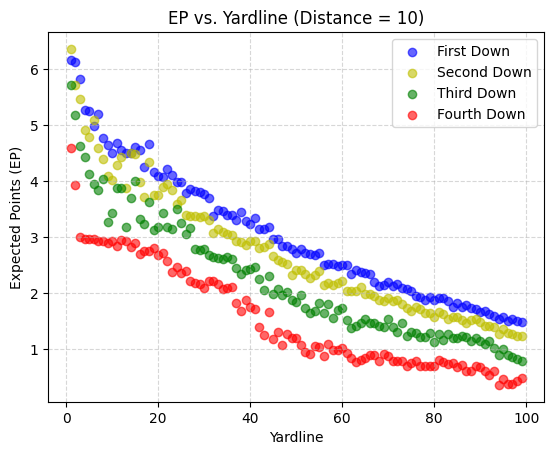

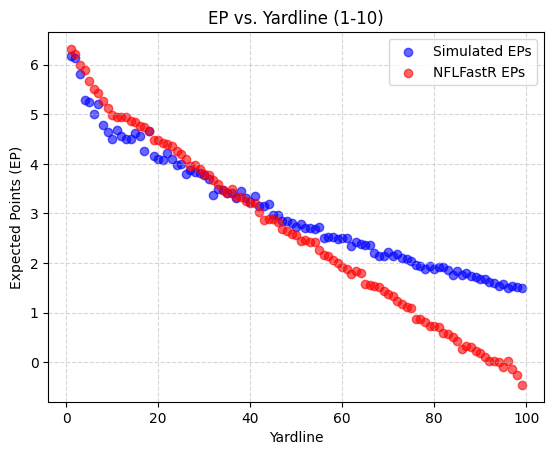

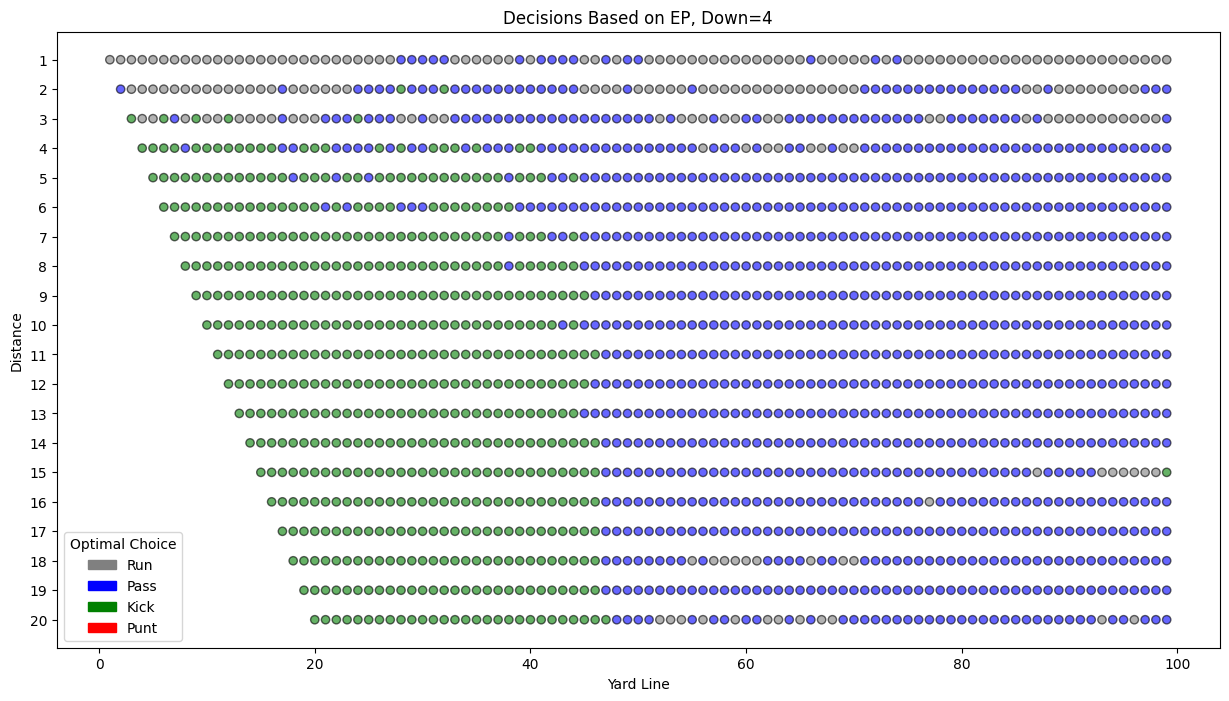

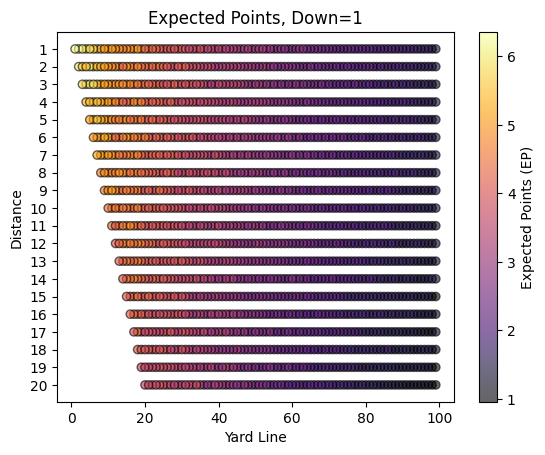

In [7]:
analyze_data('unbiased_eps/naive_eps/max_eps.csv')
plt.show()
compare_eps('unbiased_eps/naive_eps/max_eps.csv', 'nfl_pbp_data.csv')
plt.show()
predicted_decisions('unbiased_eps/naive_eps/opt_choices.csv')
plt.show()
ep_visualizer('unbiased_eps/naive_eps/max_eps.csv')
plt.show()

### EP Calculations After Three Propegations

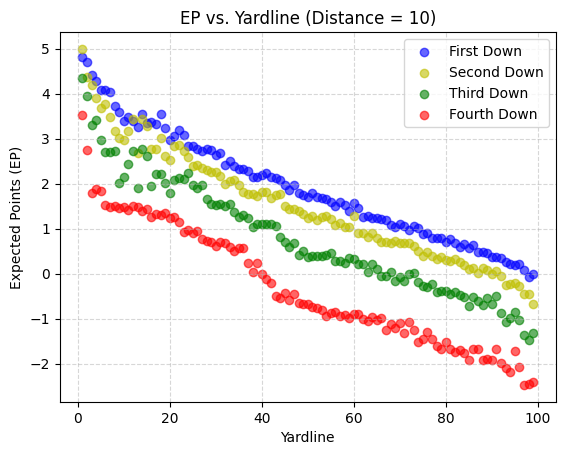

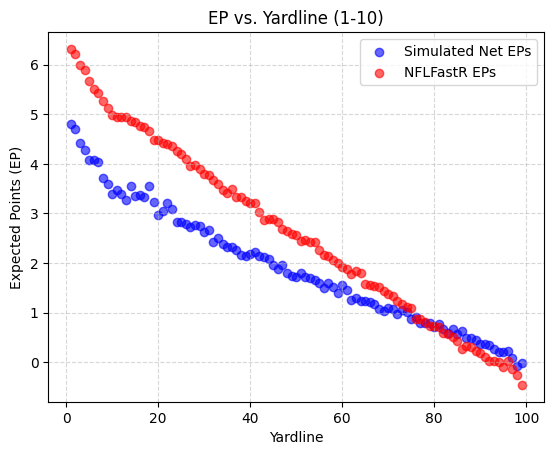

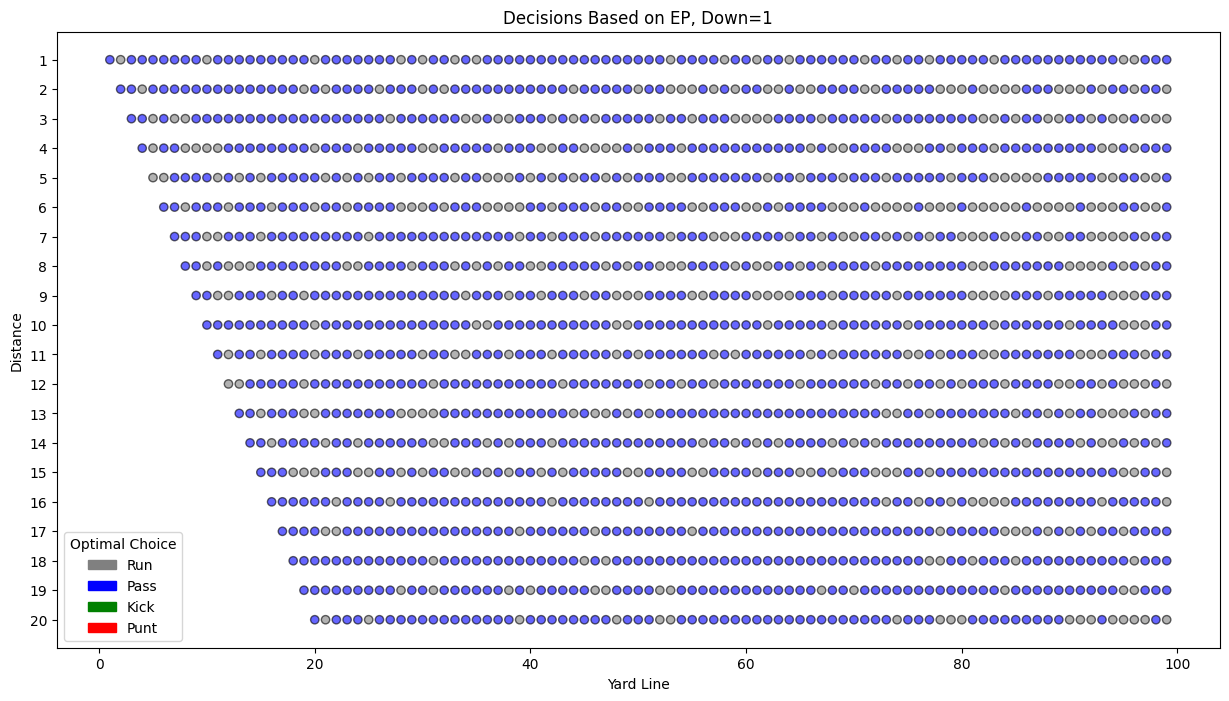

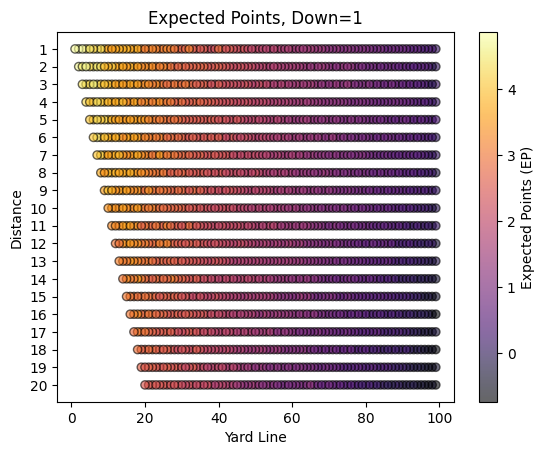

In [8]:
analyze_data('unbiased_eps/third_eps/max_eps.csv')
plt.show()
compare_eps('unbiased_eps/third_eps/max_eps.csv', 'nfl_pbp_data.csv', label1="Simulated Net EPs")
plt.show()
predicted_decisions('unbiased_eps/third_eps/opt_choices.csv', down=1)
plt.show()
ep_visualizer('unbiased_eps/third_eps/max_eps.csv')
plt.show()

### NFL EP Data

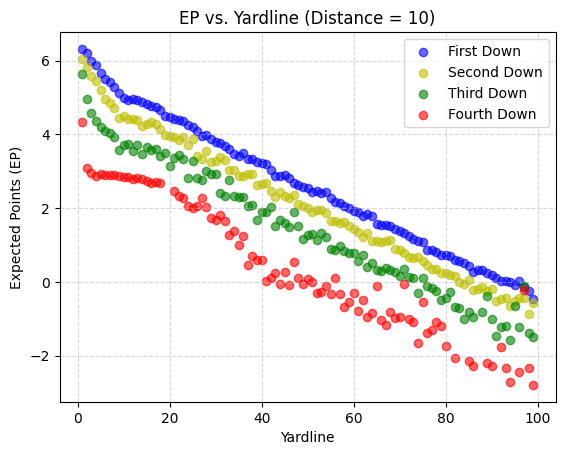

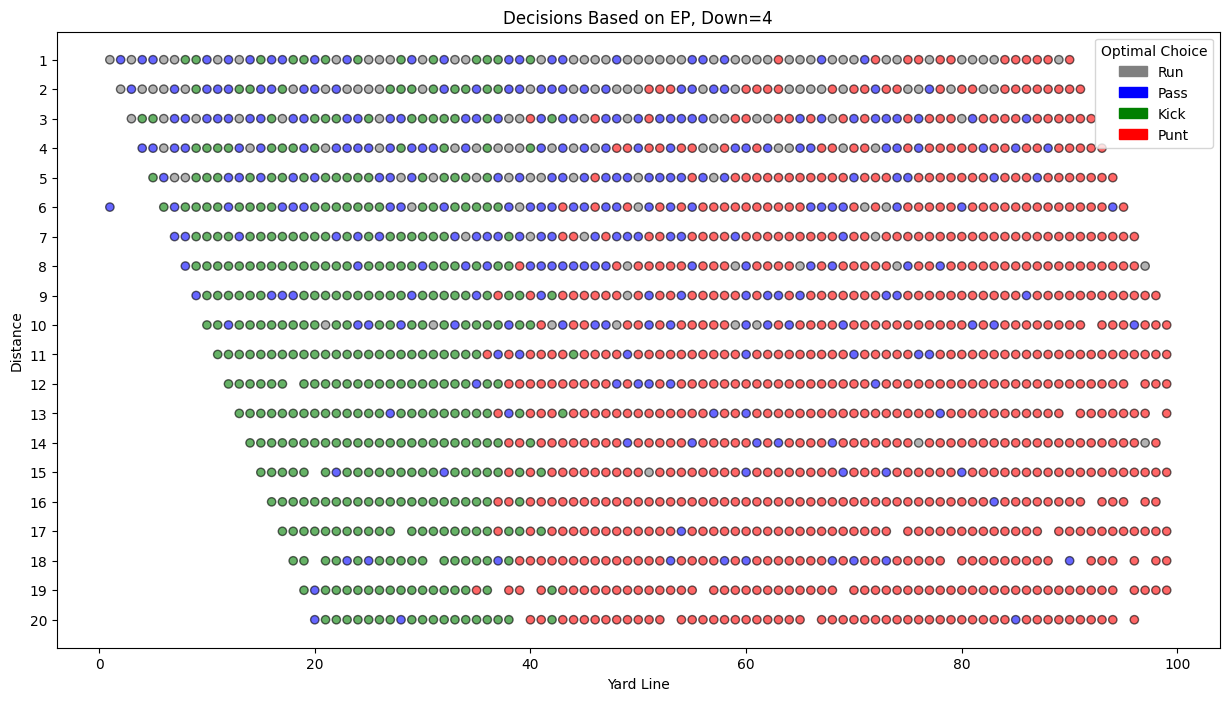

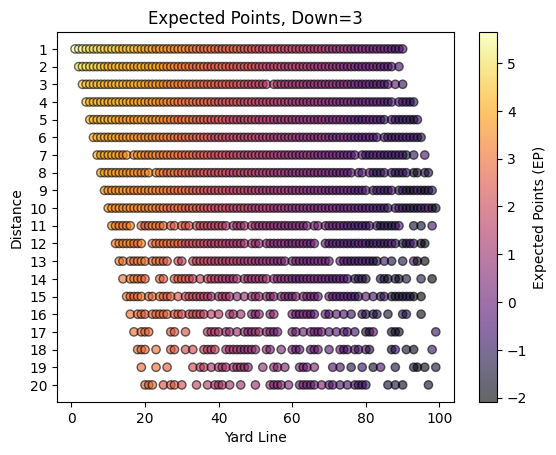

In [9]:
analyze_data('nfl_pbp_data.csv')
plt.show()
predicted_decisions('optimal_play_types.csv')
plt.show()
ep_visualizer('nfl_pbp_data.csv', down = 3)
plt.show()

### Analyzing EPOCHS

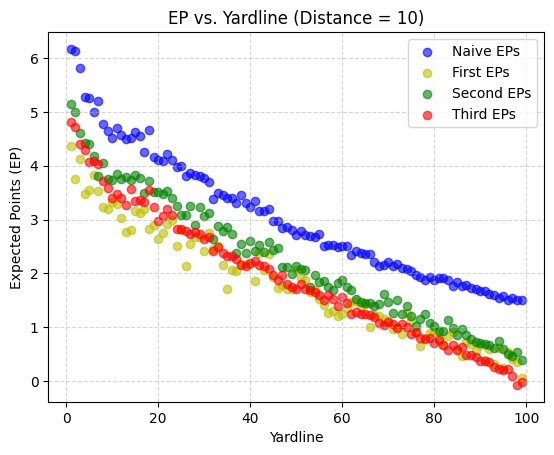

In [10]:
analyze_epochs()
plt.show()